In [1]:
import numpy as np
import random
import enum 
import scipy
from scipy import special
import functools
from typing import (
    Any, Dict, List, Optional, Mapping, Set, TypeVar, Tuple, Union, Iterator, Sequence
)
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

tf.keras.backend.set_floatx('float64')

##  load data

In [2]:
from scipy import io
mat = io.loadmat('linear_square.mat')
data_all = mat['linear_square']

In [3]:
data_all = data_all[:,:257,:]
data_all = data_all.transpose(1,0,2)
data_all.shape

(257, 30, 256)

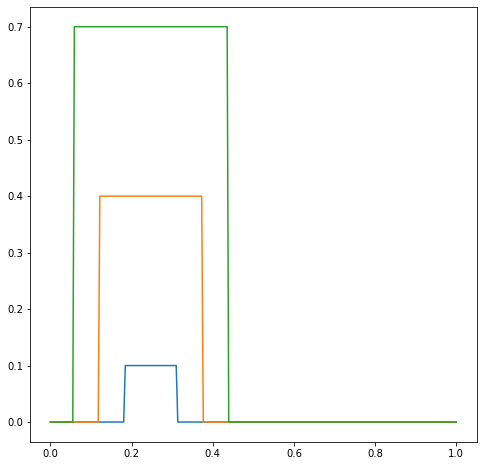

In [4]:
x_fine = np.linspace(0,1,256)
plt.figure(figsize=(8,8))
plt.plot(x_fine,data_all[0,0,:])
plt.plot(x_fine,data_all[0,10,:])
plt.plot(x_fine,data_all[0,20,:])
plt.show()

## coasen

In [5]:
data_all_coarse = np.zeros((257,30,32))
for i in range(257):
    for j in range(30):
        for k in range(32):
            data_all_coarse[i,j,k] = np.mean([data_all[i,j,k*8+p] for p  in range(8)])


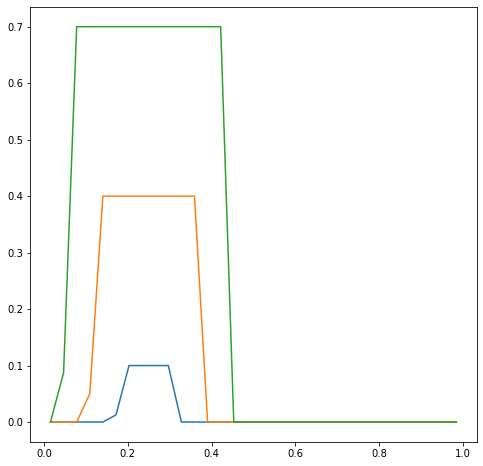

In [6]:
x_coarse = np.arange(1/64,1,1/32)
plt.figure(figsize=(8,8))
plt.plot(x_coarse,data_all_coarse[0,0,:])
plt.plot(x_coarse,data_all_coarse[0,10,:])
plt.plot(x_coarse,data_all_coarse[0,20,:])
plt.show()


## build model

In [7]:
class Conv1DPeriodic(tf.keras.layers.Layer):

    def __init__(self, filters: int, kernel_size: Sequence[int],activation, **kwargs):
        super(Conv1DPeriodic,self).__init__()
        self._layer = tf.keras.layers.Conv1D(
            filters, kernel_size, activation=activation,padding='valid')
        self.filters = self._layer.filters
        self.kernel_size = self._layer.kernel_size

        if any( size % 2 == 0 for size in self.kernel_size):
            raise ValueError('kernel size for conv1d is not odd: {}'
                        .format(self.kernel_size))


    def build(self, input_shape):
        self._layer.build(input_shape)
        super().build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.filters,)



    def pad_periodic_1d(self, inputs):
        # here we consider periodic
        padding = self.kernel_size[0]//2
        tensors = [inputs[:,-padding:,:], inputs, inputs[:,:padding,:]]
        return tf.concat(tensors, axis=1)



    def call(self, inputs):
        padded = self.pad_periodic_1d(inputs)
        result = self._layer(padded)
        # assert result.shape[1:3] == inputs.shape[1:3], (result, inputs)
        return result


In [8]:
class OutPutLayer(tf.keras.layers.Layer):

    def __init__(self, stencil_size:int = 5):
        super(OutPutLayer,self).__init__()
        self.stencil_size = stencil_size
        


    @tf.function
    def recover_coefficients(self, tensors):
        tensors = tensors - tf.math.reduce_mean(tensors,axis=-1)[...,tf.newaxis] + 1./self.stencil_size  #试试矩阵乘积
        # tensors = tf.reverse(tensors,[-1])

        y = tf.TensorArray(tf.float64, self.stencil_size)

        for i in tf.range(self.stencil_size):

            y = y.write(i,tf.roll(tensors[:,:,i],shift=-i+self.stencil_size//2,axis=1))
        
        return tf.transpose(y.stack(), [1,2,0])


    def call(self, inputs):
        
        return self.recover_coefficients(inputs)

In [9]:
def conv1d_stack(num_outputs, num_layers=6, filters=32, kernel_size=5,
                 activation='relu', **kwargs):
  """Create a sequence of Conv2DPeriodic layers."""
  model = tf.keras.Sequential()
  for _ in range(num_layers-1):
    layer = Conv1DPeriodic(
        filters, kernel_size, activation=activation, **kwargs)
    model.add(layer)
  model.add(Conv1DPeriodic(num_outputs, kernel_size, activation = activation,**kwargs))
  model.add(OutPutLayer(num_outputs))
  return model

In [10]:
class Grid():
    def __init__(self, size:int=32, domain:Tuple[float,float] = (0.,1.)):
        self.size = size
        self.domain = domain
        self.length = domain[1] - domain[0]
        assert self.length > 0
        self.step:float = self.length/self.size

        self.x = np.linspace(self.domain[0],self.domain[1], self.size + 1)

        self.xc = np.arange(self.domain[0]+self.step*0.5, self.domain[1], self.step)

In [11]:
def velocity(x,t):
    if t is not tf.Tensor:
        t = tf.convert_to_tensor(t) 


    return tf.ones_like(x,dtype=tf.float64)

In [12]:
class SLGeometry:
    def __init__(self, grid:Grid, vel=velocity):
        self.grid = grid
        self.velocity = vel

   
    def get_upstram(self, t, time_step): # t:current time
        
        Nt = t.shape[0]
        X = tf.stack([self.grid.x[:-1]]*Nt,axis=0)
        T = t + time_step

        k1 = time_step[:,tf.newaxis]*self.velocity(X, T);
        k2 = time_step[:,tf.newaxis]*self.velocity(X - 0.5*k1, T - 0.5*time_step)
        k3 = time_step[:,tf.newaxis]*self.velocity(X - 0.5*k2, T - 0.5*time_step)
        k4 = time_step[:,tf.newaxis]*self.velocity(X -     k3, T -     time_step)

       
        return - (k1 + 2*k2 + 2*k3 + k4)/6./self.grid.step 

In [13]:
slmodel = SLGeometry(Grid())


print(slmodel.get_upstram(tf.random.normal([16],dtype=tf.float64), tf.random.normal([16],dtype=tf.float64)))

tf.Tensor(
[[-33.05083965 -33.05083965 -33.05083965 -33.05083965 -33.05083965
  -33.05083965 -33.05083965 -33.05083965 -33.05083965 -33.05083965
  -33.05083965 -33.05083965 -33.05083965 -33.05083965 -33.05083965
  -33.05083965 -33.05083965 -33.05083965 -33.05083965 -33.05083965
  -33.05083965 -33.05083965 -33.05083965 -33.05083965 -33.05083965
  -33.05083965 -33.05083965 -33.05083965 -33.05083965 -33.05083965
  -33.05083965 -33.05083965]
 [-63.94242171 -63.94242171 -63.94242171 -63.94242171 -63.94242171
  -63.94242171 -63.94242171 -63.94242171 -63.94242171 -63.94242171
  -63.94242171 -63.94242171 -63.94242171 -63.94242171 -63.94242171
  -63.94242171 -63.94242171 -63.94242171 -63.94242171 -63.94242171
  -63.94242171 -63.94242171 -63.94242171 -63.94242171 -63.94242171
  -63.94242171 -63.94242171 -63.94242171 -63.94242171 -63.94242171
  -63.94242171 -63.94242171]
 [ 19.54459186  19.54459186  19.54459186  19.54459186  19.54459186
   19.54459186  19.54459186  19.54459186  19.54459186  19.54

In [ ]:
class SemiLagFiniteVolume(tf.keras.Model):

    def __init__(
        self, slmodel:SLGeometry, stencil_size=5, 
               core_model_func=conv1d_stack,
               num_time_steps=4,
               name='SemiLagFiniteVolumeModel',
               **kwargs,
        ):
        super(SemiLagFiniteVolume,self).__init__()

        self.stencil_size = stencil_size
        self.num_time_steps = num_time_steps
        self.core_model = core_model_func(stencil_size, **kwargs)
        self.slmodel = slmodel


    def pad_periodic_1d(self, inputs):
        # here we consider 
        padding = self.stencil_size//2
        tensors = [inputs[:,-padding:], inputs, inputs[:,:padding]]
        return tf.concat(tensors, axis=1)

    def call(self, inputs):
        current_time = tf.squeeze(inputs['current_time'])
        time_step = tf.squeeze(inputs['time_step'])
        solution_tensor = inputs['solution']
        solution_all = []
        for i in range(self.num_time_steps):
             
            xi = self.slmodel.get_upstram(current_time, time_step)
           
            coefficients = self.core_model(tf.stack([solution_tensor, xi],axis=2))
           
            padded = self.pad_periodic_1d(solution_tensor)
            extracted = tf.image.extract_patches(padded[...,tf.newaxis,tf.newaxis],
                                    [1, self.stencil_size, 1, 1],
                                    strides=[1, 1, 1, 1],
                                    rates=[1, 1, 1, 1],
                                    padding='VALID')

            extracted = tf.squeeze(extracted, axis=2)
            
            solution_tensor = tf.reduce_sum(coefficients*extracted,axis=2)
            solution_all.append(solution_tensor)
            current_time += time_step
        return tf.stack(solution_all,axis=2)

## make training data 

In [14]:
def make_train_data(data,output_time_step=1,delta_t=1/256*0.6,times=2):
    time_steps_all = data.shape[0]-1
    train_input = {}
    train_input_sol = data[:-output_time_step*times]
    print(train_input_sol.shape)
    current_time = np.array([[delta_t*j]*data.shape[1] for j in range(train_input_sol.shape[0])])
    current_time = tf.reshape(current_time,[current_time.shape[0]*current_time.shape[1],1])
    train_input['current_time'] = current_time
    train_input['time_step'] = np.ones(current_time.shape[0])*delta_t*times
    
    train_input_sol = train_input_sol.reshape(-1,data.shape[-1])
     
    # train_input_sol = train_input_sol[...,tf.newaxis]
    train_input['solution'] = train_input_sol
    train_output = []
    for shift in range(times, output_time_step*times+1,times):
        output_slice = data[shift:time_steps_all-output_time_step*times+shift+1]
        output_slice = output_slice.reshape(-1,data.shape[-1])
        output_slice = output_slice[...,tf.newaxis]
        train_output.append(output_slice)
    train_output = tf.concat(train_output,axis=2)
    assert  train_input['solution'].shape[0]==train_output.shape[0]
    assert  train_input['solution'].shape[1]==train_output.shape[1]
    return train_input, train_output

In [15]:
train_input, train_output = make_train_data(data_all_coarse,4)

(249, 30, 32)


In [16]:
def make_train_data_multi(data,output_time_step=4,delta_t=1/256*0.6,times_steps_all = [4,8,16]):
    train_input = {}
    train_output = []
    current_time = []
    time_step = []
    train_input_sol = []
#     times_steps_all = [1,2,4,8,16]
    for k in times_steps_all:
        train_input_temp, train_output_temp = make_train_data(data, output_time_step,delta_t,k)
        current_time.append(train_input_temp['current_time'])
        time_step.append(train_input_temp['time_step'])
        train_input_sol.append(train_input_temp['solution'])
        train_output.append(train_output_temp)
    train_input['solution'] = tf.concat(train_input_sol, axis=0)
    train_input['current_time'] = tf.concat(current_time, axis=0)
    train_input['time_step'] = tf.concat(time_step, axis=0)
    train_output = tf.concat(train_output, axis=0)
    
    return train_input, train_output
    

In [17]:
train_input, train_output = make_train_data_multi(data_all_coarse,4)#the time steps should also be coarsen

(241, 30, 32)
(225, 30, 32)
(193, 30, 32)
(169, 30, 32)


In [19]:
for key in train_input.keys():
    print(key,train_input[key].shape)

solution (24840, 32)
current_time (24840, 1)
time_step (24840,)


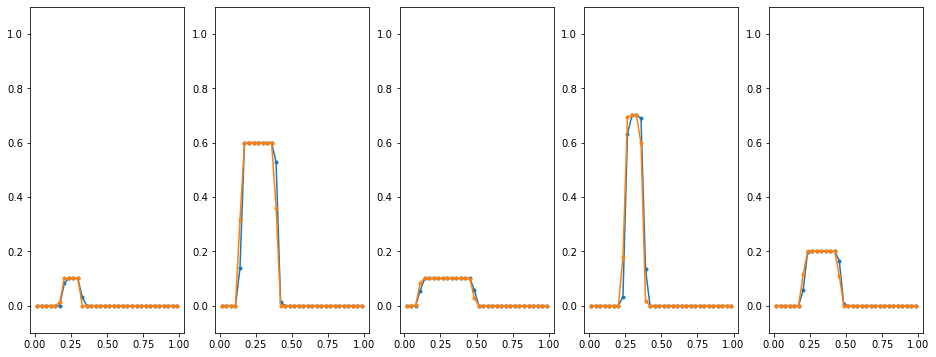

In [20]:
fig, axes = plt.subplots(1, 5, figsize=[16, 6])

for i, ax in enumerate(axes):
  ax.plot(x_coarse, train_output[256*i, :, 0], marker='.')
  ax.plot(x_coarse,train_input['solution'][256*i,:],marker='.')
  ax.set_ylim(-0.1, 1.1)

In [22]:
model = SemiLagFiniteVolume(slmodel)

In [295]:
model.compile(
    optimizer='adam', loss='mse')
    

tf.random.set_seed(123)
np.random.seed(123)

history = model.fit(
    train_input, train_output, epochs=60, batch_size=30, 
    verbose=1, shuffle=True
    )

Epoch 1/60
828/828 [==============================] - 96s 49ms/step - loss: 9.7753e-04
Epoch 2/60
828/828 [==============================] - 40s 49ms/step - loss: 5.3856e-05
Epoch 3/60
828/828 [==============================] - 41s 49ms/step - loss: 2.6369e-05
Epoch 4/60
828/828 [==============================] - 40s 48ms/step - loss: 2.4037e-05
Epoch 5/60
828/828 [==============================] - 41s 50ms/step - loss: 2.1464e-05
Epoch 6/60
828/828 [==============================] - 41s 49ms/step - loss: 2.7620e-05
Epoch 7/60
828/828 [==============================] - 41s 50ms/step - loss: 1.0497e-05
Epoch 8/60
828/828 [==============================] - 41s 49ms/step - loss: 4.2508e-05 1s 
Epoch 9/60
828/828 [==============================] - 41s 49ms/step - loss: 7.7839e-06
Epoch 10/60
828/828 [==============================] - 41s 49ms/step - loss: 1.2767e-05
Epoch 11/60
828/828 [==============================] - 41s 50ms/step - loss: 7.4032e-06 0s - loss: 7.4115
Epoch 12/60
828/828

## test

In [24]:
data_test_coarse = np.squeeze(data_all_coarse[0,:,:])

In [25]:
test_example = {}
test_example['solution'] = data_test_coarse
test_example['current_time'] = np.ones(data_test_coarse.shape[0])*0
test_example['time_step'] = np.ones(data_test_coarse.shape[0])*1/256*0.6*8

In [26]:
def run_pred(initial_condition,pred_time_steps):
    if pred_time_steps==0:
        solution = initial_condition['solution']
    for k in range(pred_time_steps):
        solution = model(initial_condition)[:,:,-1]
        new_condition = {}
        new_condition['solution'] = tf.squeeze(solution)
        new_condition['current_time'] = initial_condition['current_time'] + initial_condition['time_step']*4
        new_condition['time_step'] = initial_condition['time_step']
        initial_condition = new_condition
    return solution

In [27]:
def show(time_steps):
    
        
    solution_test = run_pred(test_example,time_steps)
    
    fig, axes = plt.subplots(1,5, figsize=[16,3])
    for i, ax in enumerate(axes):
        ax.plot(x_coarse, solution_test[5*i, :], marker='*',label='nn')
        ax.plot(x_coarse,data_all_coarse[time_steps*8,5*i,:],marker='.',label='ref')
        ax.set_ylim(-0.1, 1.1)
        ax.set_title('t='+str(8*time_steps))
        ax.legend(loc='best')


    plt.show()

l_infty 0.10095917942621527
l_infty 0.20206508884651167
l_infty 0.4027951692226489
l_infty 0.6021642349035048
l_infty 0.7025862122461748


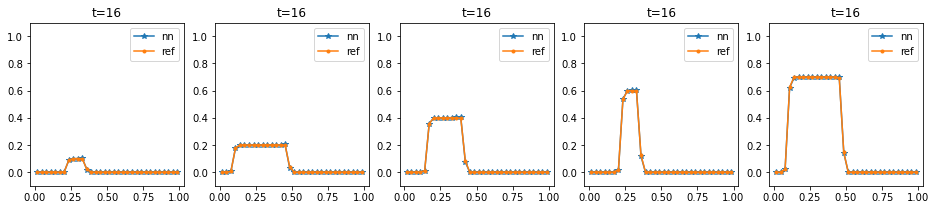

In [28]:
show(2)

## mass error

In [ ]:
mat1 = io.loadmat[''linear_square_coarse]

In [111]:
data_test = mat1['linear_square_coarse']

In [112]:
data_test = data_test.transpose(1,0,2)

In [113]:
data_test.shape

(54, 30, 32)

In [114]:
data_test_init = np.squeeze(data_test[0,:,:])

In [115]:
test_example = {}
test_example['solution'] = data_test_init
test_example['current_time'] = np.ones(data_test_init.shape[0])*0
test_example['time_step'] = np.ones(data_test_init.shape[0])*1/256*0.6*4

In [452]:
def run_collect():
    solution_all = []
    initial_condition = test_example
    solution_all.append(initial_condition['solution'][...,tf.newaxis])
    for k in range(16):
        solution = model(initial_condition)
        solution_all.append(solution)
        new_condition = {}
        new_condition['solution'] = tf.squeeze(solution[:,:,-1])
        new_condition['current_time'] = initial_condition['current_time'] + initial_condition['time_step']*4
        new_condition['time_step'] = initial_condition['time_step']
        initial_condition = new_condition
    return tf.concat(solution_all,axis=2)

In [453]:
solution_test_all = run_collect()

In [454]:
solution_test_all.shape

TensorShape([30, 32, 65])

In [455]:
def mass_error():
    error1 = np.zeros((33,1))
    error2 = np.zeros((33,1))
    error3 = np.zeros((33,1))
    for i in range(33):
        error1[i]=tf.abs(tf.reduce_sum(solution_test_all[9,:,2*i])-tf.reduce_sum(data_test[0,9,:]))
        error2[i]=tf.abs(tf.reduce_sum(solution_test_all[13,:,2*i])-tf.reduce_sum(data_test[0,13,:]))
        error3[i]=tf.abs(tf.reduce_sum(solution_test_all[16,:,2*i])-tf.reduce_sum(data_test[0,16,:]))
    time_all = np.linspace(0,256,33)
    plt.plot(time_all, error1,c='b',label = 'Sample = 0')
    plt.plot(time_all, error2, c='g', label='Sample = 1')
    plt.plot(time_all, error3, c='y', label='Sample = 2')
    plt.title('Mass error')
    plt.legend(loc='best')
    plt.show()